In [1]:
import torch
from datasets.pascal_voc import create_voc_dataloaders, VOC_CLASSES, VOC_COLORMAP
import matplotlib.pyplot as plt
import numpy as np
import torch
from unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from train import train_one_epoch, validate
import json

In [2]:
base_path = 'data'  # base path of where the Pascal VOC dataset is stored
train_loader, val_loader, test_loader = create_voc_dataloaders(
    base_path=base_path,
    batch_size=8,
    num_workers=4
)



Missing files:
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000006.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000011.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000012.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000018.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000024.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000030.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000031.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000046.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000047.png
Missing mask: data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000048.png
... and 1446 more


ValueError: Dataset files are missing

In [3]:
images, masks = next(iter(train_loader))
print(f"Image size: {images.size()}")
print(f"Mask size: {masks.size()}")

[ WARN:0@6.142] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/2010_005725.jpg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@6.142] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/2011_001475.jpg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@6.145] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/2009_001481.jpg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@6.147] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/2010_000371.jpg.jpg'): can't open/read 

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/teamspace/studios/this_studio/unet-image-segmentation/datasets/pascal_voc.py", line 80, in __getitem__
    raise ValueError(f"Image not found at {img_path}")
ValueError: Image not found at data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/data/pascal-voc/VOC2012_train_val/VOC2012_train_val/JPEGImages/2010_005725.jpg.jpg


In [4]:
# Setup for training
num_classes = len(VOC_CLASSES)  # 21 classes (20 + background)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create color palette dictionary from VOC_COLORMAP
COLOR_PALETTE = {i: tuple(color) for i, color in enumerate(VOC_COLORMAP)}


Pascal VOC Classes and Colors:


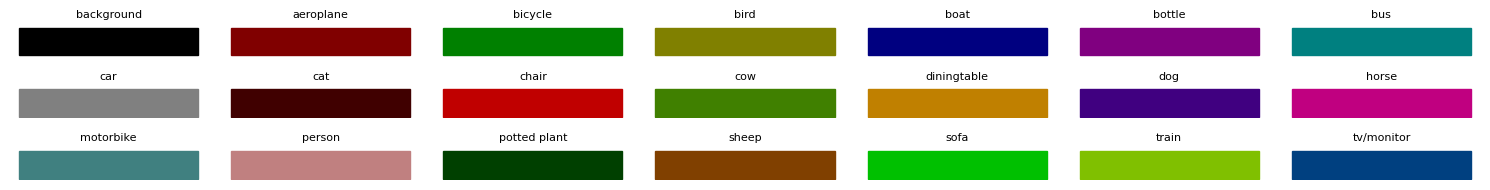


Example Training Samples:


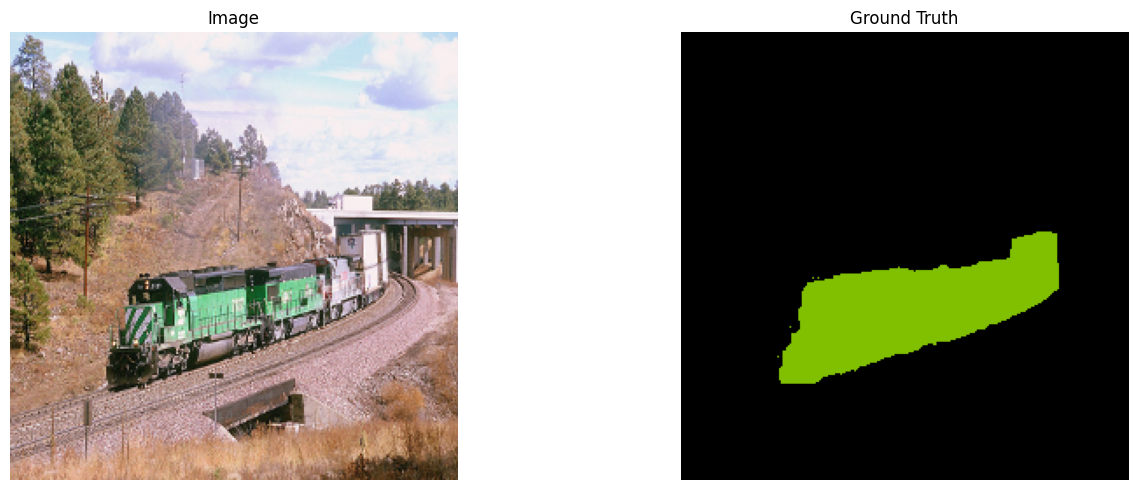

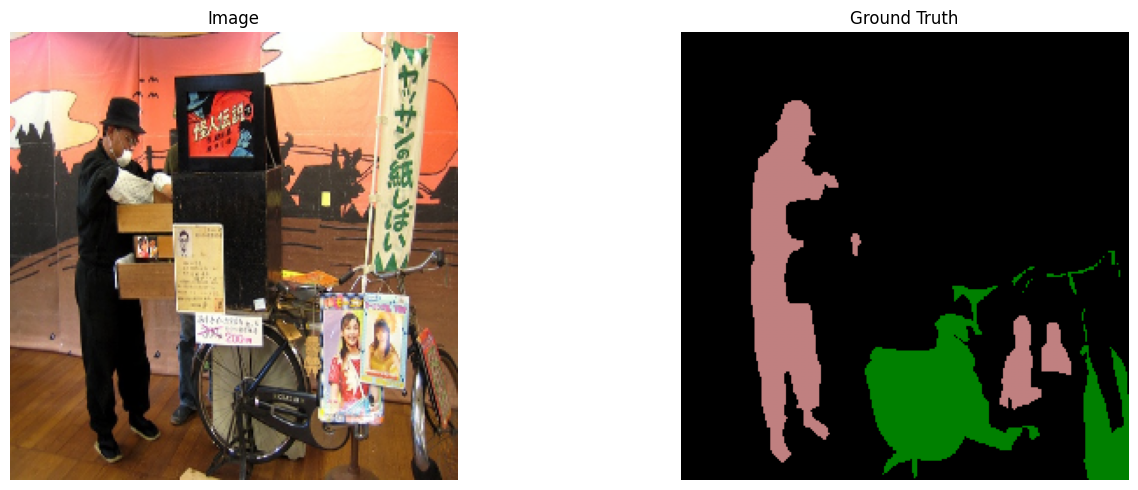

'\n# During training loop:\nwith torch.no_grad():\n    val_images, val_masks = next(iter(val_loader))\n    val_images = val_images.to(device)\n    predictions = model(val_images)\n\n    print("\nValidation Samples with Predictions:")\n    plot_batch_samples(val_images, val_masks, predictions, num_samples=2)\n'

In [5]:
# Function to create a colormap legend
def create_colormap_legend(figsize=(15, 2)):
    """Create a legend showing the Pascal VOC classes and their corresponding colors"""
    n_classes = len(VOC_CLASSES)
    n_cols = 7  # Number of columns in the legend
    n_rows = (n_classes + n_cols - 1) // n_cols  # Calculate required number of rows

    plt.figure(figsize=figsize)
    for i, (class_name, color) in enumerate(zip(VOC_CLASSES, VOC_COLORMAP)):
        row = i // n_cols
        col = i % n_cols

        # Create a small colored rectangle for each class
        plt.subplot(n_rows, n_cols, i + 1)
        plt.fill([0, 1, 1, 0], [0, 0, 1, 1], color=[x/255 for x in color])
        plt.axis('off')
        plt.title(class_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Function to plot images and masks
def plot_sample(image, mask, prediction=None):
    """
    Plot the image, ground truth mask, and prediction (if provided)
    Args:
        image: Tensor of shape (C, H, W)
        mask: Tensor of shape (H, W)
        prediction: Optional tensor of shape (C, H, W)
    """
    n_subplots = 3 if prediction is not None else 2
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, n_subplots, 1)
    img = image.permute(1, 2, 0).cpu().numpy()
    # Denormalize image
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image')

    # Plot ground truth mask
    plt.subplot(1, n_subplots, 2)
    mask_colored = np.zeros((*mask.shape, 3))
    mask_np = mask.cpu().numpy()
    for class_idx, color in enumerate(VOC_COLORMAP):
        mask_colored[mask_np == class_idx] = [x/255 for x in color]
    plt.imshow(mask_colored)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot prediction if provided
    if prediction is not None:
        plt.subplot(1, n_subplots, 3)
        pred = torch.argmax(prediction, dim=0).cpu().numpy()
        pred_colored = np.zeros((*pred.shape, 3))
        for class_idx, color in enumerate(VOC_COLORMAP):
            pred_colored[pred == class_idx] = [x/255 for x in color]
        plt.imshow(pred_colored)
        plt.axis('off')
        plt.title('Prediction')

    plt.tight_layout()
    plt.show()

# Function to plot batch of samples
def plot_batch_samples(images, masks, predictions=None, num_samples=4):
    """
    Plot a batch of samples
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Optional tensor of shape (B, C, H, W)
        num_samples: Number of samples to plot
    """
    num_samples = min(num_samples, len(images))

    for i in range(num_samples):
        if predictions is not None:
            plot_sample(images[i], masks[i], predictions[i])
        else:
            plot_sample(images[i], masks[i])
        plt.show()

# Display the colormap legend
print("Pascal VOC Classes and Colors:")
create_colormap_legend()

# Get a batch of samples and visualize them
images, masks = next(iter(train_loader))
print("\nExample Training Samples:")
plot_batch_samples(images, masks, num_samples=2)

# Example usage during training/validation:
"""
# During training loop:
with torch.no_grad():
    val_images, val_masks = next(iter(val_loader))
    val_images = val_images.to(device)
    predictions = model(val_images)

    print("\nValidation Samples with Predictions:")
    plot_batch_samples(val_images, val_masks, predictions, num_samples=2)
"""

In [6]:
class EarlyStopping:
    """Early stopping callback similar to Keras implementation"""
    def __init__(
        self,
        monitor='val_loss',
        min_delta=0.0,
        patience=5,
        verbose=1,
        mode='min',
        restore_best_weights=True
    ):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.mode = mode
        self.restore_best_weights = restore_best_weights

        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = float('inf') if mode == 'min' else float('-inf')

    def __call__(self, epoch, model, current):
        if self.mode == 'min':
            improved = current < (self.best - self.min_delta)
        else:
            improved = current > (self.best + self.min_delta)

        if improved:
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.verbose > 0:
                    print(f'Early stopping triggered at epoch {epoch}')
                if self.restore_best_weights and self.best_weights is not None:
                    if self.verbose > 0:
                        print('Restoring best weights')
                    model.load_state_dict(self.best_weights)
                return True
        return False

In [7]:
model = UNet(n_channels=3, n_classes=num_classes).to(device)
criterion = CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [8]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'learning_rates': []
}

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, num_classes)

    # Validation phase
    val_loss, val_metrics = validate(model, val_loader, criterion, device, num_classes)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_metrics['iou'])
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val IoU: {val_metrics['iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Print per-class IoU
    print("\nPer-class IoU:")
    for cls_idx, cls_name in enumerate(VOC_CLASSES):
        iou_key = f'class_{cls_idx}_iou'
        if iou_key in val_metrics:
            print(f"{cls_name}: {val_metrics[iou_key]:.4f}")

    # Check early stopping
    if early_stopping(epoch, model, val_loss):
        print(f"\nTraining stopped early at epoch {epoch+1}")
        break

# Save the final model and history
torch.save(model.state_dict(), 'pascal_voc_ce_final_model.pth')
with open('pascal_voc_ce_training_history.json', 'w') as f:
    json.dump(history, f)


Epoch 1/2


100%|██████████| 183/183 [01:17<00:00,  2.37it/s, loss=1.95]
[ WARN:0@85.894] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000006.png'): can't open/read file: check file path/integrity
[ WARN:0@85.896] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000047.png'): can't open/read file: check file path/integrity
[ WARN:0@85.905] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000083.png'): can't open/read file: check file path/integrity
[ WARN:0@85.909] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000156.png'): can't open/read file: check file path/integrity
[ WARN:0@85.910] global loadsave.cpp:241 findDecoder imread_('data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000171.png'): can't open/read file: check file path/inte

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/teamspace/studios/this_studio/unet-image-segmentation/datasets/pascal_voc.py", line 67, in __getitem__
    raise ValueError(f"Mask not found at {mask_path}")
ValueError: Mask not found at data/pascal-voc/VOC2012_test/VOC2012_test/SegmentationClass/2008_000006.png


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Validation IoU')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model and run predictions
import torch
from unet import UNet
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import CrossEntropyLoss
from train import validate

def plot_predictions(images, masks, predictions, n_samples=4):
    """
    Plot images, ground truth masks, and predicted masks side by side
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Tensor of shape (B, C, H, W)
        n_samples: Number of samples to display
    """
    # Get predictions
    pred_masks = torch.argmax(predictions, dim=1)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()
        mask_colored = np.zeros((*mask.shape, 3))
        for class_idx, color in enumerate(VOC_COLORMAP):
            mask_colored[mask == class_idx] = [x/255 for x in color]
        axes[i, 1].imshow(mask_colored)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Ground Truth')

        # Plot predicted mask
        pred_mask = pred_masks[i].cpu().numpy()
        pred_colored = np.zeros((*pred_mask.shape, 3))
        for class_idx, color in enumerate(VOC_COLORMAP):
            pred_colored[pred_mask == class_idx] = [x/255 for x in color]
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Prediction')

    plt.tight_layout()
    plt.show()

def get_batch_predictions(model, data_loader, num_batches=1):
    """
    Get predictions for a few batches from the data loader
    """
    model.eval()
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            predictions = model(images)

            all_images.append(images)
            all_masks.append(masks)
            all_predictions.append(predictions)

    return (torch.cat(all_images, 0),
            torch.cat(all_masks, 0),
            torch.cat(all_predictions, 0))

# Load the best model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = len(VOC_CLASSES)  # 21 classes (20 + background)
loaded_model = UNet(n_channels=3, n_classes=num_classes).to(device)
loaded_model.load_state_dict(torch.load('pascal_voc_ce_final_model.pth'))
loaded_model.eval()

# Get predictions for a few test batches
test_images, test_masks, test_predictions = get_batch_predictions(loaded_model, test_loader, num_batches=1)

# Plot the results
plot_predictions(test_images, test_masks, test_predictions, n_samples=4)

# Calculate and print metrics for the test set
criterion = CrossEntropyLoss()
test_loss, test_metrics = validate(loaded_model, test_loader, criterion, device, num_classes)
print("\nTest Set Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"IoU: {test_metrics['iou']:.4f}")
print(f"Dice Score: {test_metrics['dice']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")

# Print per-class IoU scores
print("\nPer-class IoU scores:")
for class_idx, class_name in enumerate(VOC_CLASSES):
    iou_key = f'class_{class_idx}_iou'
    if iou_key in test_metrics:
        print(f"{class_name}: {test_metrics[iou_key]:.4f}")

# Optional: Create a confusion matrix visualization
import seaborn as sns

def plot_confusion_matrix(metrics):
    plt.figure(figsize=(15, 15))
    conf_matrix = metrics['confusion_matrix']

    # Create labels for classes
    labels = VOC_CLASSES

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_metrics)

# Create legend for class colors
print("\nPascal VOC Classes and Colors:")
create_colormap_legend()